In [1]:
# For reloading modules
import importlib

# My modules config has to be imported first
import config as cfg
import datasets
import utils
import models
import train

import display as disp

import time
import tensorflow as tf
import numpy as np

# Video and visualization stuff
import tqdm
import PIL.Image, PIL.ImageDraw

from IPython.display import Image, HTML, clear_output, Video
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from visdom import Visdom

In [10]:
# Reload modules
importlib.reload(utils)
importlib.reload(models)
importlib.reload(datasets)
importlib.reload(cfg)
importlib.reload(train)
importlib.reload(disp)

<module 'display' from '/home/maxi/Documents/UNI/Thesis/dev/SoS/display.py'>

In [2]:
# tf.config.run_functions_eagerly(True)

# Load Dataset & Model & Trainer
(x_train, y_train), (x_test, y_test) = datasets.get_data()
ca = models.CAModel()

# In order to use visdom, visdom.sh has to be executed
vis = Visdom()
trainer = train.Trainer(x_train, y_train, ca, vis)
utils.save_cfg()
ca.summary()
print(utils.get_cfg_infos())

(40, 40, 4)


Setting up a new session...


Successfully saved configs at:  logs/maybe/2020_11_24/14_33_32/
------------
Model: "dmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 16)]      0         
_________________________________________________________________
perceive (Conv2D)            (None, 40, 40, 128)       18560     
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 16)        2064      
Total params: 20,624
Trainable params: 20,624
Non-trainable params: 0
_________________________________________________________________
dmodel:  None
{}{}{}{'SESSION_ID': '2020_11_24/14_33_32'}


(40, 320, 4)


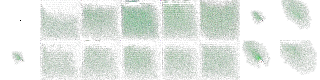

 r: 0 step: 238, full_loss: 159.296

In [ ]:
NUM_RUNS = 1
cfg.TRAIN.NUM_TRAINING_STEPS = 1000

for e in range(NUM_RUNS):
  if e > 0:
    ca = models.CAModel()
    trainer = train.Trainer(x_train, y_train, ca, vis)
  
  for i in range(1, cfg.TRAIN.NUM_TRAINING_STEPS+1):
    x0, x_out, losses, grads = trainer.full_train_step()
    trainer.visualize(x0, x_out, losses, grads, e)
  
  plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos())
  # utils.save_fig(plot, name=f"fig_{e}", as_img=False)


In [43]:
# Show plot from above and plot it to visdom
# importlib.reload(disp)

plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos())
plot.show()
# utils.save_json(plotly.io.to_json(plot))
# utils.save_fig(plot, as_img=True)
vis.plotlyplot(plot) # , env="present")

'window_390c5dc9070226'

In [4]:
# ---------- PLOT AVERAGE SESSION -----------------
# importlib.reload(utils)
# importlib.reload(disp)

# sess_id = "2020_11_14/13_09_57"
sess_id = cfg.EXTRA.SESSION_ID

fig = disp.plot_avg_session(sess_id)
# fig.update_yaxes(type="log")

vis.plotlyplot(fig)
fig.show()


In [4]:
# --- PLOT COLLECTION OF AVERAGE PLOTS ----
# importlib.reload(disp)
plots = utils.grid_plots_simple_nov
disp.plot_collection_of_avg_plots(plots)

In [4]:
# --- Test Performance of ca over time, starting from x_train -------

import textwrap

x = trainer.x_train[0:1]
y = trainer.y_train[0]


def test_emoji(x, y):
  loss_arr = []
  for i in range(cfg.WORLD.CA_STEP_RANGE[1] + 150):
    loss = trainer.individual_l2_loss(x,y)
    loss_arr.append(loss)
    x = trainer.ca(x)

  # fig = disp.plot_loss(np.array(loss_arr)[:,0], plot_mean=False, return_plot=True)
  fig = go.Figure(go.Scatter(y=np.array(np.array(loss_arr)[:,0])))
  return fig
  
# TODO all this things not here...
fig = test_emoji(x, y)
title = utils.get_cfg_infos()
fig.layout.title.text = "<br>".join(textwrap.wrap(title, width=120))
fig.layout.title.font.size = 12
fig.show()
# vis.plotlyplot(fig)

In [5]:
# ---- VIDEO -----

# Bigger padding around img (cfg.WORLD.SIZE for standard size)
x_big = datasets.add_padding(x_train[0], cfg.WORLD.SIZE + 0)[None, :]

# Y image as start
expanded_y = np.zeros_like(x_train[0:1])
expanded_y[:,:,:,0:4] = y_train[0:1]

# Cut image as start
x_cut = trainer.cut_x(trainer.pool_t[:8])[0:1]

# Create and show video
disp.show_simple_run(x_big, trainer.ca, cfg.WORLD.CA_STEP_RANGE[0] + 500 , only_alive_cells=False)
# vis.video(videofile="./_autoplay.mp4")

(40, 40, 16)


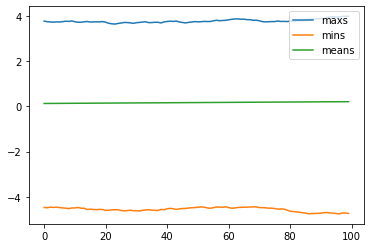

In [50]:
maxs = []
mins = []
means= []

x_all,y = trainer.get_new_emoji_x_y()
x = x_all[0:8]
for i in range(100):
  maxs.append(np.amax(x))
  mins.append(np.amin(x))
  means.append(np.mean(x))
  x = trainer.ca(x)
  
plt.plot(maxs, label="maxs")
plt.plot(mins, label="mins")
plt.plot(means, label="means")
plt.legend()
plt.show()

get_new_x_y
mean: 0.0008771225116800343


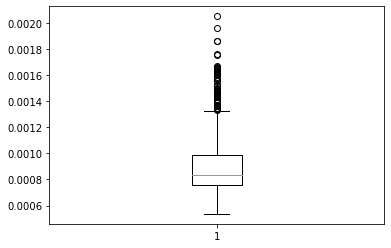

full_train_step
mean: 0.0853380825353778


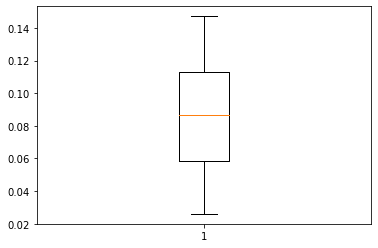

visualize
mean: 0.0022452206776224417


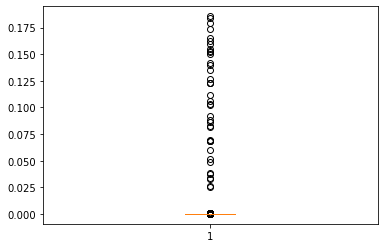

In [18]:
# -- Show execution times as boxplots ---

for key in utils.total_time_dict.keys():
  print(key)
  print("mean:", np.mean(utils.total_time_dict[key][1:]))
  # Removing the first as most time too long and not representative
  plt.boxplot(utils.total_time_dict[key][1:])
  plt.show()

In [ ]:
# --- Test performance (function) on MNIST set ---

# TODO outsource
def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = models.eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
  return all_accuracies, all_agreements


In [ ]:
# --- Call and exectue the test of performance on the MNIST set ----

eval_batch = 1000
num_iters = 10

# TODO this takes ages!
start_time = time.time()
all_accuracies, all_agreements = eval_all(trainer.ca, num_steps=200, mutate=True)
print("All Acc time: ", time.time() - start_time)

plt.figure(figsize=(10, 4))
plt.title('Average cell accuracy over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average cell accuracy (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_accuracies, label="ca")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Average total agreement across batch over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average total agreement (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_agreements, label="ca")
plt.legend()